In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime, timedelta

# Set basic plot style
sns.set_theme()

# Load all datasets
print("Loading datasets...")
climate_df = pd.read_excel("Cleaned_Climate_Data (2).xlsx")
mortality_df = pd.read_excel("Cleaned_Mortality_Data (2).xlsx")
roots_df = pd.read_excel("Cleaned_Roots_Data (1).xlsx")
pest_datos2_df = pd.read_excel("Full_Cleaned_Pest_Disease_Datos2.xlsx")
pest_datos1_df = pd.read_excel("Rebuilt_Cleaned_Pest_Disease_Translated.xlsx")

Loading datasets...


In [5]:
# Preprocess all datasets
print("\nPreprocessing data...")
for df in [climate_df, mortality_df, roots_df, pest_datos2_df, pest_datos1_df]:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Optimize memory usage
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int32')


Preprocessing data...



Analyzing pest trends...


<Figure size 1200x600 with 0 Axes>

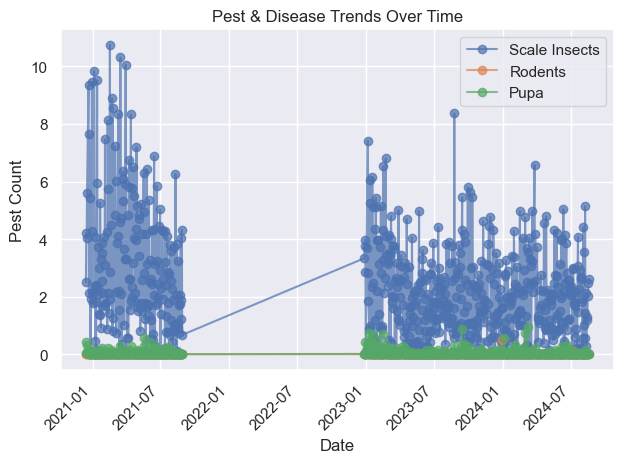

In [7]:
# 1. Analyze Pest Trends
print("\nAnalyzing pest trends...")
pest_grouped = pest_datos2_df.groupby('Date')[['Scale Insects', 'Rodents', 'Pupa']].sum()

plt.figure(figsize=(12, 6))
pest_grouped.plot(marker='o', linestyle='-', alpha=0.7)
plt.title('Pest & Disease Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Pest Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pest_trends_over_time.png')
plt.show()


Generating pest forecast...


C:\Users\anubh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anubh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anubh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anubh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

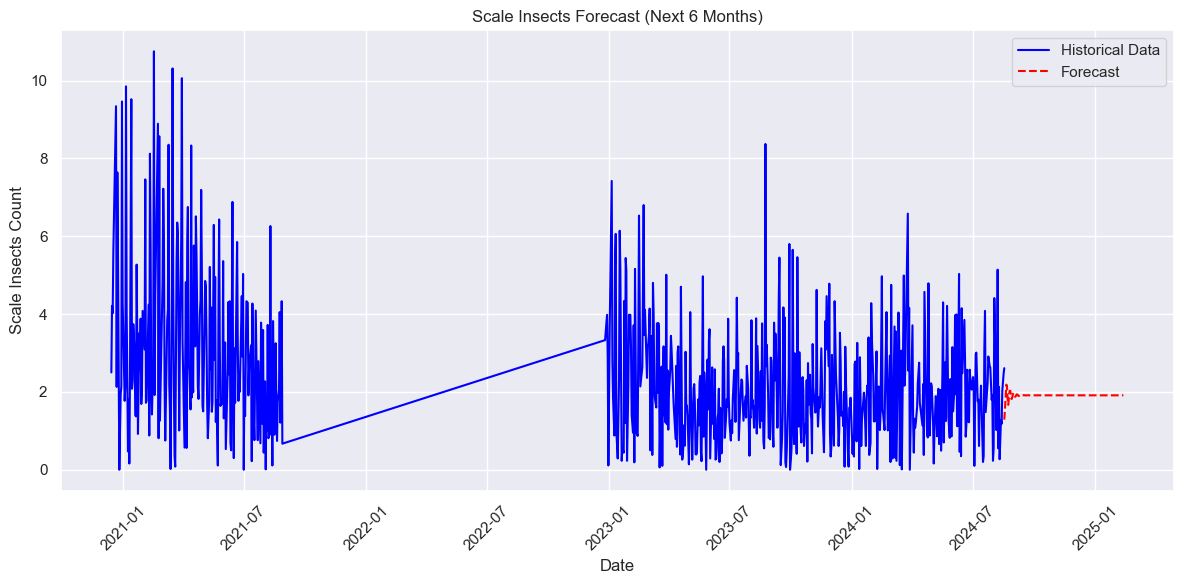

In [9]:
# 2. ARIMA Forecasting
print("\nGenerating pest forecast...")
scale_insects_series = pest_grouped['Scale Insects'].dropna()
arima_model = ARIMA(scale_insects_series, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Generate 6-month forecast
forecast_days = 180
forecast = arima_model_fit.forecast(steps=forecast_days)
future_dates = pd.date_range(start=scale_insects_series.index[-1], periods=forecast_days, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(scale_insects_series.index, scale_insects_series, label='Historical Data', color='blue')
plt.plot(future_dates, forecast, label='Forecast', linestyle='--', color='red')
plt.title('Scale Insects Forecast (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Scale Insects Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pest_forecast.png')
plt.show()


Detecting anomalies...


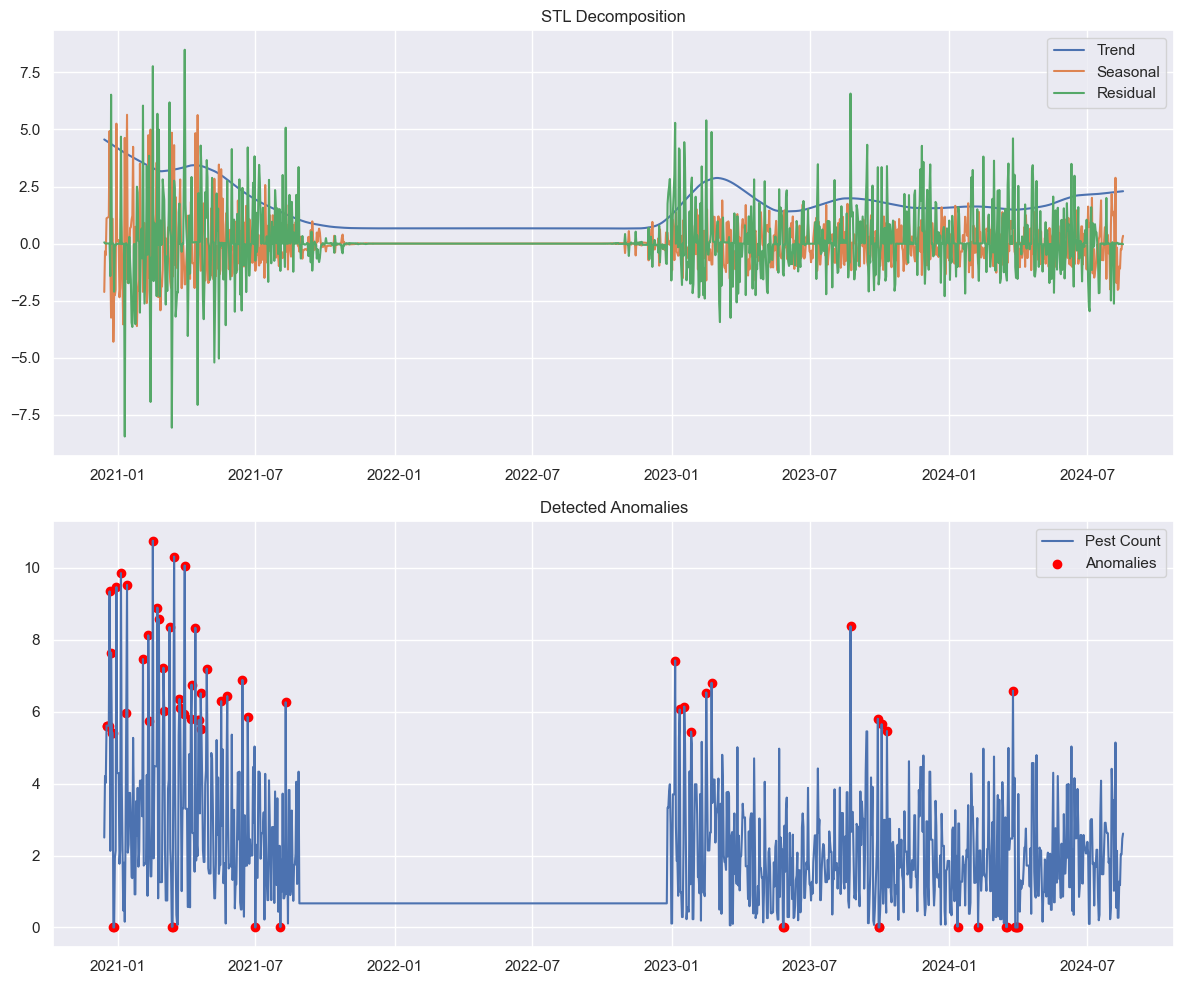

In [13]:
# 4. Anomaly Detection
print("\nDetecting anomalies...")
pest_series = pest_grouped['Scale Insects'].asfreq('D').ffill()

try:
    # STL Decomposition
    stl = STL(pest_series, period=31, robust=True)
    result = stl.fit()
    
    # Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(pest_series.values.reshape(-1, 1))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # STL Decomposition plot
    ax1.plot(result.trend, label='Trend')
    ax1.plot(result.seasonal, label='Seasonal')
    ax1.plot(result.resid, label='Residual')
    ax1.set_title('STL Decomposition')
    ax1.legend()
    
    # Anomalies plot
    ax2.plot(pest_series.index, pest_series.values, label='Pest Count')
    anomaly_points = pest_series[anomalies == -1]
    ax2.scatter(anomaly_points.index, anomaly_points.values, color='red', label='Anomalies')
    ax2.set_title('Detected Anomalies')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('STL Decomposition.png')
    plt.show()
    
except ValueError as e:
    print(f"Error in STL decomposition: {e}")
    print("Using alternative anomaly detection method...")
    
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(pest_series.values.reshape(-1, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(pest_series.index, pest_series.values, label='Pest Count')
    anomaly_points = pest_series[anomalies == -1]
    plt.scatter(anomaly_points.index, anomaly_points.values, color='red', label='Anomalies')
    plt.title('Detected Anomalies (Simple Method)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Detected Anomalies.png')
    plt.show()


Training prediction model...

Missing values in features:
Week               549
Year               549
Temperature        549
Avg Temperature    549
Max Temperature    549
Min Temperature    549
Heat Index         550
Humidity           550
Avg Humidity       550
Max Humidity       550
Min Humidity       550
Soil Moisture      550
Rainfall           550
Solar Radiation    550
dtype: int64


C:\Users\anubh\AppData\Local\Temp\ipykernel_26476\2250240748.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.index, y=feature_importance.values, palette="coolwarm")


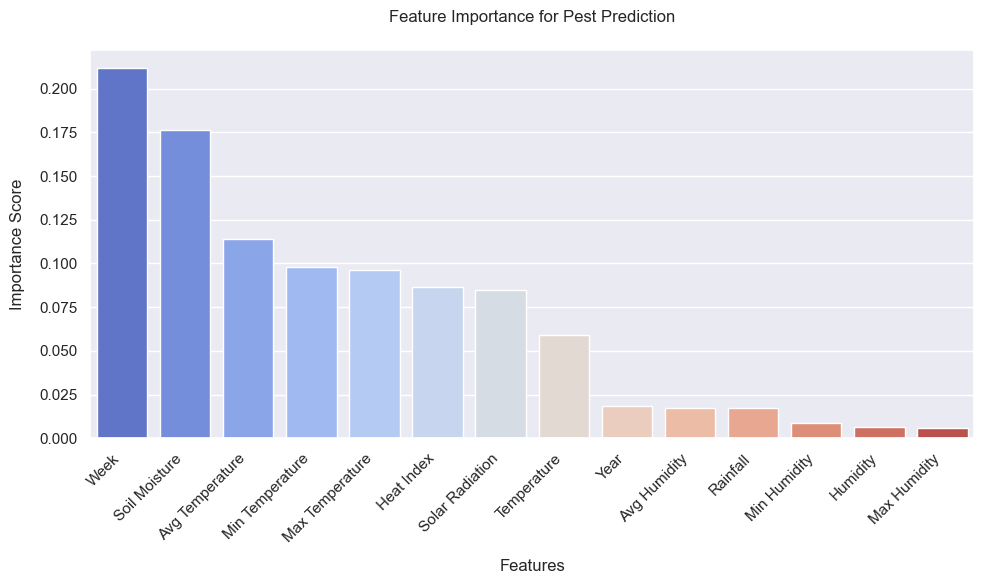


Model Performance:
Mean Absolute Error: 1.33
R² Score: 0.46

Feature Importance Rankings:
Week: 0.2116
Soil Moisture: 0.1763
Avg Temperature: 0.1137
Min Temperature: 0.0981
Max Temperature: 0.0963
Heat Index: 0.0862
Solar Radiation: 0.0847
Temperature: 0.0592
Year: 0.0183
Avg Humidity: 0.0174
Rainfall: 0.0170
Min Humidity: 0.0086
Humidity: 0.0066
Max Humidity: 0.0059


In [15]:
# 5. Predictive Modeling
print("\nTraining prediction model...")

# Prepare features and target
X = climate_pest_df.drop(['Date', 'Scale Insects', 'Rodents', 'Pupa'], axis=1)
y = climate_pest_df['Scale Insects']

# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum())

# Handle missing values using SimpleImputer
from sklearn.impute import SimpleImputer

# Create and fit the imputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split data after imputation
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate feature importance and create DataFrame
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Create color map based on feature importance values
import seaborn as sns
n_features = len(feature_importance)
colors = sns.color_palette("coolwarm", n_features)

# Create feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.index, y=feature_importance.values, palette="coolwarm")
plt.title('Feature Importance for Pest Prediction', pad=20)
plt.xlabel('Features', labelpad=10)
plt.ylabel('Importance Score', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Feature Importance.png')
plt.show()

print('\nModel Performance:')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R² Score: {r2:.2f}')

# Print feature importance values
print('\nFeature Importance Rankings:')
for feature, importance in feature_importance.items():
    print(f'{feature}: {importance:.4f}')

In [5]:
import pandas as pd

# Read the weather data summarized by month
climate_df1 = pd.read_csv("2023-2024_climate_monthly.csv")

# Read the pest data summarized by month
pest_df1 = pd.read_csv("2023-2024_pest_monthly.csv")

# Ensure 'Year-Month' is used as the key column for merging
climate_df1["Year-Month"] = climate_df1["Year-Month"].astype(str)
pest_df1["Year-Month"] = pest_df1["Year-Month"].astype(str)

# Merge weather data and pest data
merged_df = pd.merge(pest_df1, climate_df1, on="Year-Month", how="inner")

# Display the merged data
print(merged_df.head())


  Year-Month  Larva Type  Fresh Damage Type  Old Damage Type  \
0    2023-01        25.0               26.0             64.0   
1    2023-02        12.0               10.0             34.0   
2    2023-03       120.0              148.0            210.0   
3    2023-04       104.0               92.0            437.0   
4    2023-05       254.0              247.0            541.0   

   Egg without hatching  Egg With Hatching  S. LARVA   Fresh Damage Stage  \
0                   5.0               38.0    10597.0              2054.0   
1                  13.0               25.0     9446.0              1225.0   
2                  33.0              123.0     7442.0              1005.0   
3                  26.0              140.0     4511.0               600.0   
4                  55.0              113.0     1686.0               304.0   

   Old Damage Stage   Pupa  Scale Insects  Rodents  Weevil Damage  \
0           10385.0  460.0         6955.0      0.0          161.0   
1            8

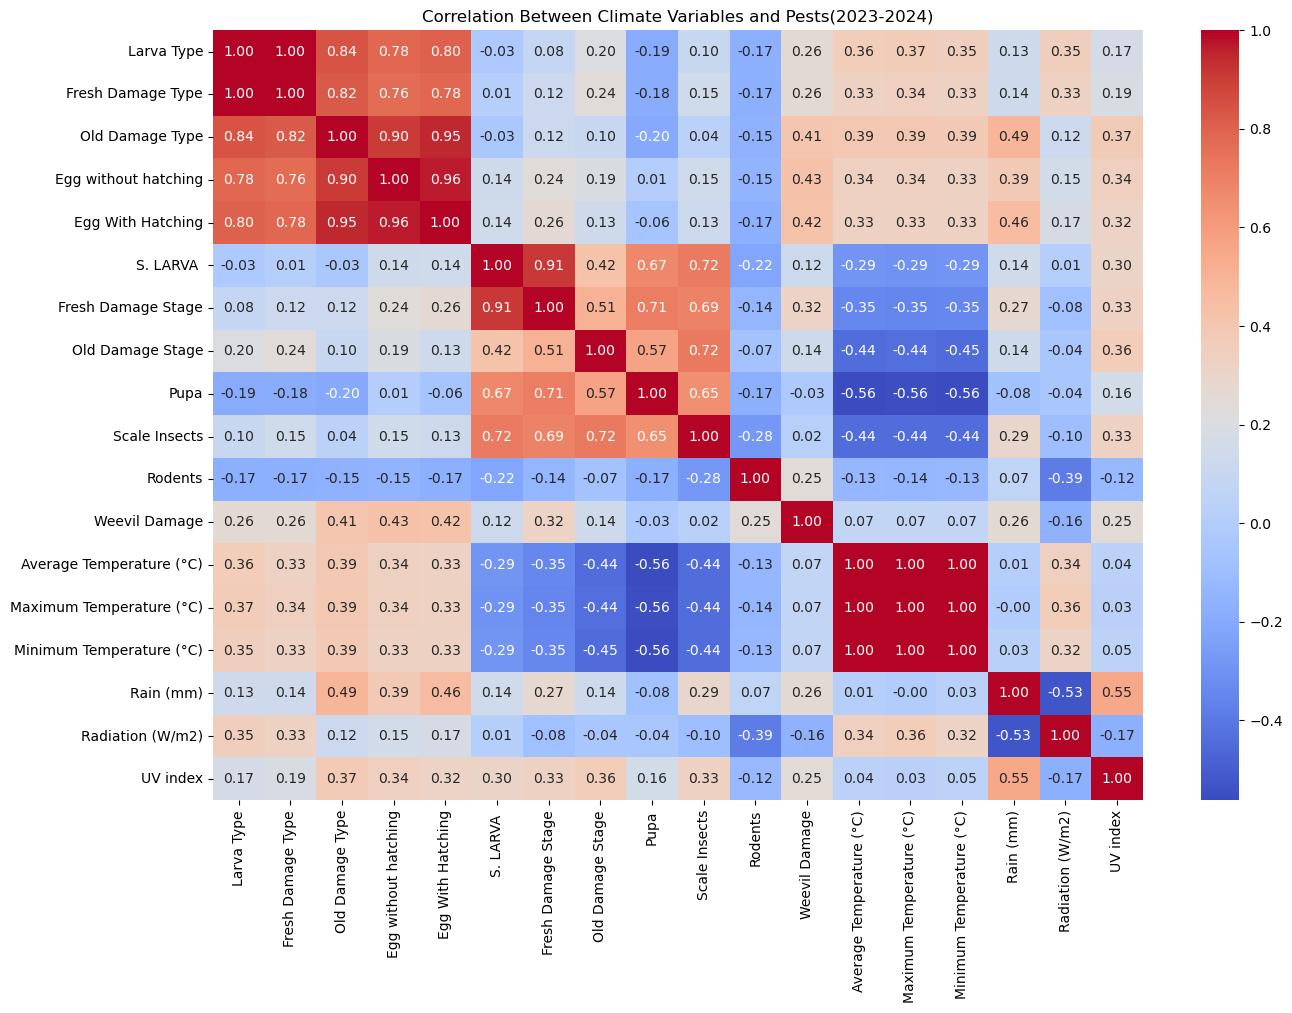

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = merged_df.select_dtypes(include=["number"])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Climate Variables and Pests(2023-2024)")
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()